In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [60]:
## Imports 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout, Concatenate,Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall,F1Score





tf.random.set_seed(42)

In [23]:
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv',sep=',')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [24]:
## Load color images
hmnist_8_rgb = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv', sep=',')
hmnist_28_rgb = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv', sep=',')

#Load grayscale images
hmnist_8_l = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv', sep=',')
hmnist_28_l= pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv', sep=',')

First of all, we proceed to enconde the `dx` column , so after that we can map with the image dataset, so in this way we are sure about the classes of skin type.

In [25]:
le = LabelEncoder()
skin_df['label'] = le.fit_transform(skin_df['dx'])   ##remember that is just for concatenate
print(skin_df['label'].shape)
y = to_categorical(skin_df['label'])
print(f'El tamaño de y es {y.shape}')

(10015,)
El tamaño de y es (10015, 7)


Doing this, we've just replaced the label column, and our image pixels are totally untouched! So it is safe to merge the dataset!

In [26]:
hmnist_8_rgb['label'] = skin_df['label'].values
hmnist_28_rgb['label'] = skin_df['label'].values
hmnist_8_l['label'] = skin_df['label'].values
hmnist_28_l['label'] = skin_df['label'].values

Before merging each dataset, it could be useful to double check the row order, based that they don't have any common column, but they have the same length.

In [27]:
## Checking size of each; we should get a True as result

(hmnist_8_rgb['label'] == skin_df['label']).value_counts()

label
True    10015
Name: count, dtype: int64

Ok, so as a summary the following steps will be:

* Merge each image dataset with the main one; so we get 4 dataset in total.
* Reshape and normalize each --> This is because the data comes flattered; so we need to reshape into 2D/3D form. For RGB images for instance, this would be 28x28x3 (height x width x color)
* Train CNN

In [28]:
df_8_rgb = pd.concat([hmnist_8_rgb.reset_index(drop=True), skin_df.reset_index(drop=True)], axis=1)
df_28_rgb = pd.concat([hmnist_28_rgb.reset_index(drop=True), skin_df.reset_index(drop=True)], axis=1)
df_8_l = pd.concat([hmnist_8_l.reset_index(drop=True), skin_df.reset_index(drop=True)], axis=1)
df_28_l = pd.concat([hmnist_28_l.reset_index(drop=True), skin_df.reset_index(drop=True)], axis=1)

## Image Dataset

In [29]:
## For this case, we will use slicing the dataframe, and also meta_cols as parameter in case that the metadata grow.;

def reshape(df, meta_cols=9, df_name='name'):
    X = df.iloc[:,:-meta_cols].values  ## Retrieve the entire df except last column
    #if return_y:   #it returns the labels
       # y = df.iloc[:,:-meta_cols].values   #assuming label is the first column
    # We can determine if the images are 2D or 3D
    num_columns = X.shape[1]


    if num_columns == 8*8:
        X = X.reshape(-1,8,8,1)  #Reshape to 8x8 grayscale - 1 channel
        print(f'Reshaping for {df_name} - 8*8*1 - grayscale')
    elif num_columns == 8*8*3:
        X = X.reshape(-1,8,8,3)  #Reshape to 8x8 RGB - 3 channel
        print(f'Reshaping for {df_name} - 8*8*3 - RGB')
    elif num_columns == 28*28:   
        X = X.reshape(-1,28,28,1)  #Reshape to 28x28 grayscale - 1 channel
        print(f'Reshaping for {df_name} - 28*28*1 - grayscale')
    elif num_columns == 28*28*3:
        X = X.reshape(-1,28,28,3)   #Reshape to 28x28 RGB - 3 channel
        print(f'Reshaping for {df_name} - 28*28*3 - RGB')
    else:
        raise ValueError('Unexpected number of columns')
    X = X.astype('float32')   #convert the pixel to float32 and divide by 255 to scale the values to [0,1]
    X = X/255

    
    return X

Ok, as next step we need to call the funcion reshape for each dataset, and as a result we obtained a new reshape and normalize dataset.

In [30]:
X_img = reshape(df_8_rgb, meta_cols=9,df_name='df_8_rgb')   #where X = img tensor, and y = label

Reshaping for df_8_rgb - 8*8*3 - RGB


# Metadata EDA

Let's proceed to start working with the metadata! In this case, we will include the `target label` so we can plot some figures, and understand the relationship btw them.

In [31]:
meta_cols=['dx','dx_type','age','sex','localization']

skin_input = df_8_rgb[meta_cols].copy()

Similar with tabular dataset, we need to treat each of our columns from metadata, most of them are categorical except of `age`. Also, we should check that there are no missing values as well. Quick overview about the categorical variables, we can identify that is more 'popular' a `nv` category, for `male` and also, appear most on the `back`.

In [32]:
skin_input.describe(include='object')

,dx,dx_type,sex,localization
count,10015,10015,10015,10015
unique,7,4,3,15
top,nv,histo,male,back
freq,6705,5340,5406,2192


Here, we realize that there are a few missing values based that the top row doesn't reach 10015, so we have 57 Nan.

In [33]:
skin_input.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


Also, in  the first table above, appears that `sex` column has 3 different values, let's check which one is the other:

In [34]:
skin_input['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

It could be possible that is related with the 'age' column based that appear the same number of records.

It is clear that the predominant value is `nv` with more than 50% of the observations, then it follow `mel`and `bkl` with around ~10%. This means that `nv` is the **dominant class**

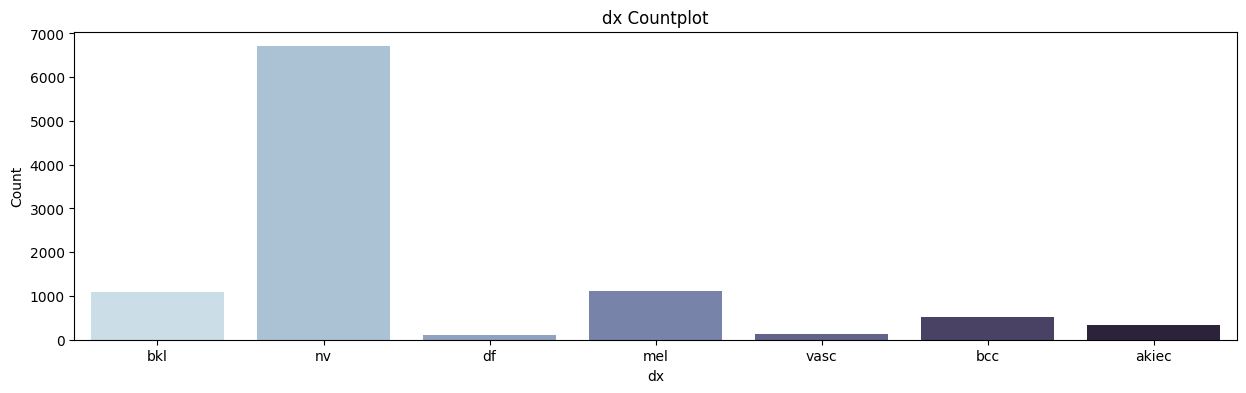

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: proportion, dtype: float64


In [35]:
plt.figure(figsize=(15,4))
sns.countplot(data=skin_input, x='dx', palette = "ch:s=.25,rot=-.25")
plt.title('dx Countplot')
plt.ylabel('Count')
plt.show()

print(skin_input['dx'].value_counts(normalize=True))

In overall, as we saw in the describe table, the value that appears most is `male`, and there are a few unkown value for `nv`. 

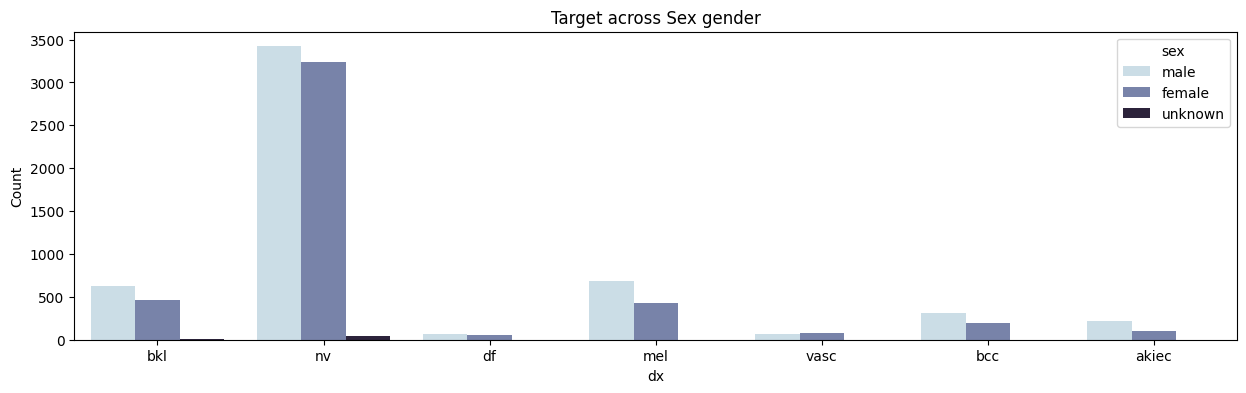

In [36]:
plt.figure(figsize=(15,4))
sns.countplot(data=skin_input, x='dx', hue='sex', palette='ch:s=.25,rot=-.25')
plt.title('Target across Sex gender')
plt.ylabel('Count')
plt.show()

For the next variable, we know that is high correlated with the target, based that is the type of `dx`; then we have `histo`which appears in each value, however `follow_up` ocurrec just in the predominant class. We keep it for now, but keeping in mind that maybe that variable produces overleaking.

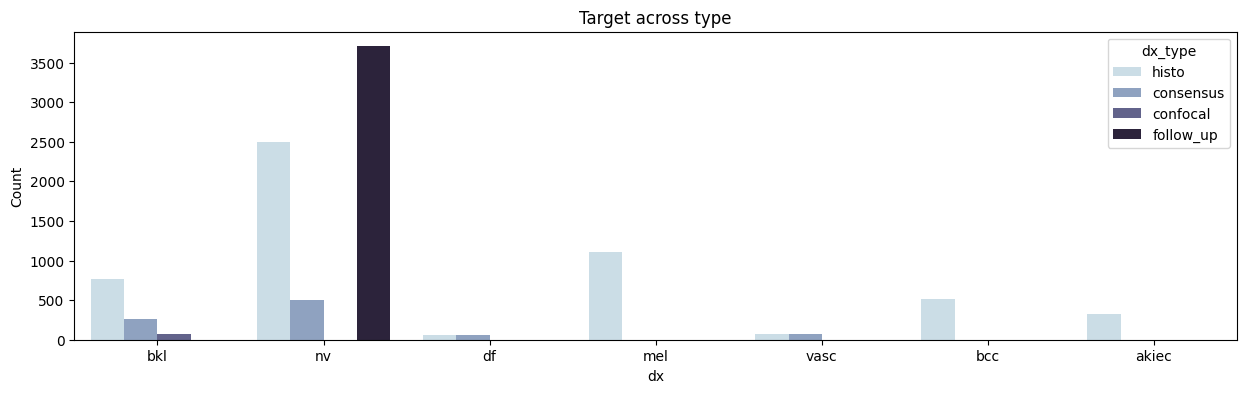

In [37]:
plt.figure(figsize=(15,4))
sns.countplot(data=skin_input, x='dx', hue='dx_type', palette='ch:s=.25,rot=-.25')
plt.title('Target across type')
plt.ylabel('Count')
plt.show()

We distinguish that the illness start appearing in their 50s, specially the `nv` which is the more frequent that we have in our dataset.

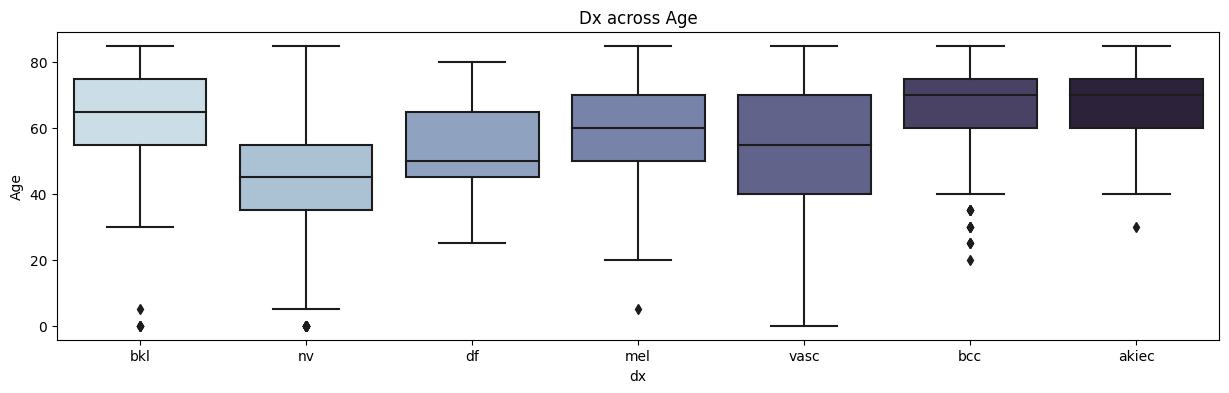

In [38]:
plt.figure(figsize=(15,4))
sns.boxplot(data=skin_input, x ='dx', y='age', palette = 'ch:s=.25,rot=-.25')
plt.title('Dx across Age')
plt.ylabel('Age')
plt.show()

<u>Sum up</u>: 

* **`dx_type`** : keep for now 
* **`age`** : impute, don't drop --> It seems that is related with unkown value from Sex column; maybe adding a flag column.
* **`dx_type`**,**`sex`** ,**`localization`**  : use one-hot-enconding because we don't want to assume any ordering at all

In [39]:
def meta_eda(df, meta_cols, df_name='name'):
    df_skin = df[meta_cols].copy()
    y_drop = skin_input['dx']
    df_skin = df_skin.drop(columns='dx')
    ## Age -- Create Flag 
    df_skin['age_missing'] = df_skin['age'].isna().astype(int)
    ## Impute with the median
    df_skin['age'] = df_skin['age'].fillna(df_skin['age'].median())
    ## Normalized age
    df_skin['age'] = StandardScaler().fit_transform(df_skin[['age']])
    ## One-Hot-Encoding
    df_skin = pd.get_dummies(df_skin, columns=['sex','dx_type','localization'])
    
    meta_features = df_skin.columns.tolist()  #to use later in cnn
    
    X_meta = df_skin[meta_features].values
    X_meta = X_meta.astype('float32')   ##to be sure that there is not any 'object' type that failed later in the cnn
    print(f'The EDA process for {df_name} finish successfully')
    return X_meta

# CNN Building

In [40]:
## Call reshape function for each Image Dataset

X_img= reshape(df_8_rgb, meta_cols=9, df_name='df_8_rgb')   #where X = img tensor, and y = label

## Metadata Input

#X_meta = skin_input[meta_features].values
X_meta = meta_eda(df_8_rgb, meta_cols, df_name='df_8_rgb')

Reshaping for df_8_rgb - 8*8*3 - RGB
The EDA process for df_8_rgb finish successfully


For this notebook, we cannot use a Sequential model, based that we need to prepare a dual-input CNN, one for image data and the other one for the metada-

[https://keras.io/guides/functional_api/](http://)

In [41]:
### Create dual input CNN

##img_shape = X_img.shape[1:]   --> (28,28,3)
## REMEMBER THAT num_classes = LABELS (7)
 
def dual_input_model(X_img, X_meta, y):

    img_shape = X_img.shape[1:]
    meta_shape = X_meta.shape[1]
    num_classes = y.shape[1]
    
    # Image input
    image_input = Input(shape=img_shape, name='image_input')

    x=Conv2D(32,(3,3), activation='relu', padding='same')(image_input)
    x=MaxPooling2D()(x)
    x=Conv2D(64,(3,3), activation='relu',padding='same')(x)
    x=MaxPooling2D()(x)
    x=Flatten()(x)
    x=Dense(64, activation='relu')(x)
    x=BatchNormalization()(x)

    # Metadata
    meta_input=Input(shape=(meta_shape,), name='meta_input')

    y=Dense(32, activation='relu')(meta_input)
    y=BatchNormalization()(y)
    y=Dropout(0.3)(y)

    # Combine both
    combined=Concatenate()([x,y])
    z=Dense(64, activation='relu')(combined)
    z=Dropout(0.5)(z)
    output=Dense(num_classes, activation='softmax', name='output')(z)

    #Build model
    model=Model(inputs=[image_input,meta_input], outputs=output, name='SkinLesion')
    return model
    

In [42]:
def compile_model(X_img, X_meta,y):
    model=dual_input_model(X_img, X_meta,y)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',Precision(),Recall(),F1Score()])
    model.summary()
    return model

In [43]:
model_8_rgb = compile_model(X_img, X_meta,y)

2025-05-19 09:02:00.126185: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "SkinLesion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 8, 8, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 32)       │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 4, 4, 32)       │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 4, 4, 64)       │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 2, 2, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 256)            │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │            800 │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         16,448 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ batch_normalization[0… │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          6,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            455 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,687 (170.65 KB)

 Trainable params: 43,495 (169.90 KB)

 Non-trainable params: 192 (768.00 B)

In [44]:
### Double check of the size of each variable before fit

print(X_img.shape, y.shape, X_meta.shape)
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_img, X_meta, y, test_size=0.2, random_state=42)  

(10015, 8, 8, 3) (10015, 7) (10015, 24)


In [45]:
def fit_model(X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test, model):
    #we used stratify to handle the class imbalance -- so it makes sure that the class dist in training and validation is similar to the original one. UPDATED: removed due an error
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
    model.fit([X_img_train, X_meta_train], y_train, epochs=10, batch_size=32, validation_data=([X_img_test,X_meta_test],y_test), callbacks=[early_stopping])
    score = model.evaluate([X_img_test,X_meta_test], y_test)
    print(f'The process is finished')
    return score

In [48]:
score_8_rgb = fit_model(X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test, model_8_rgb)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5621 - f1_score: 0.2160 - loss: 1.2672 - precision: 0.7761 - recall: 0.3968 - val_accuracy: 0.6855 - val_f1_score: 0.1646 - val_loss: 0.8566 - val_precision: 0.9241 - val_recall: 0.5592
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7045 - f1_score: 0.3052 - loss: 0.7873 - precision: 0.8525 - recall: 0.6085 - val_accuracy: 0.7199 - val_f1_score: 0.2778 - val_loss: 0.7070 - val_precision: 0.8946 - val_recall: 0.5846
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7263 - f1_score: 0.3451 - loss: 0.7208 - precision: 0.8536 - recall: 0.6157 - val_accuracy: 0.7264 - val_f1_score: 0.2626 - val_loss: 0.8211 - val_precision: 0.8172 - val_recall: 0.6720
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7233 - f1_score: 0.3292 - loss: 0.7045 - precision: 0.8525 - recall: 0.6265 - val_accuracy: 0.7004 - val_f1_score: 0.2087 - val_loss: 0.9106 - val_precision: 0.7771 - val_recall

In [50]:
def metrics(score):
    print(f'Loss: {round(score[0],3)}, Accuracy: {round(score[1],3)}, Precision: {round(score[2],3)}, Recall: {round(score[3],3)}, F1Score: {score[4]}')

We can notice that F1Score is really low for the class 0, 1, 3 and 6. Also class 5 performes amazing which we can guess that maybe is the majority class `nv`.

In [70]:
metrics(score_8_rgb)

Loss: 0.707, Accuracy: 0.72, Precision: 0.895, Recall: 0.585, F1Score: [0.05405404 0.10101008 0.479452   0.         0.4282907  0.8814566
 0.        ]


In [52]:
results={}

results['8x8_RGB'] = score_8_rgb

In [75]:
def plot_metrics(X_img_test,X_meta_test,y_test,model):
   # y_pred_prob = model.predict([X_img_test, X_meta_test])
    y_pred_classes = y_pred.argmax(axis=1)
    y_true_classes = y_test.argmax(axis=1)

    report_dic=classification_report(y_true_classes,y_pred_classes, target_names=le.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dic).transpose()
    report_df = report_df.round(2)  #rounds values for clarity
    report_df.style.background_gradient(cmap='Blues').format({'precision': "{:.2f}", 'recall': "{:.2f}", 'f1-score': "{:.2f}"})

    ConfusionMatrixDisplay.from_predictions(
        y_true_classes, y_pred_classes,
        display_labels=le.classes_,
        cmap='Blues',
        normalize=None
    )
    
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

    return report_df.style.background_gradient(cmap='Blues').format({'precision': "{:.2f}", 'recall': "{:.2f}", 'f1-score': "{:.2f}"})

Let's break down to understand how our model for 8x8x3 perform:

* For `akiec` we got a 0.40 precision, however a recall = 0.03 --> This means that when the model predicts akiec it is right 40% of the time but just the 3% were correctly predicted; the remaining 97% were missclassified. We can add more information about this, with the confusion matrix we got that the model classified correctly 2 records, however if we go to the intersection akiec-bkl appears a 47 --> In other words, the model classified as bkl instead of akiec. It means that if we sum the entire row except of 2; we got 67 falses negatives cases. Also, we have 2 True Positives so 2/69 ~ 0.029 (Recall value)
* `mel`: For this case, the moels predicts correctly 109 cases, however it missclassified 51 records as bkl and 66 as nv. 
  

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


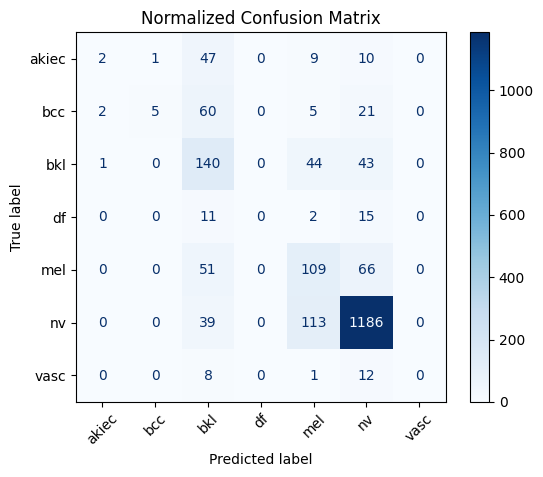

,precision,recall,f1-score,support
akiec,0.40,0.03,0.05,69.000000
bcc,0.83,0.05,0.10,93.000000
bkl,0.39,0.61,0.48,228.000000
df,0.00,0.00,0.00,28.000000
mel,0.39,0.48,0.43,226.000000
nv,0.88,0.89,0.88,1338.000000
vasc,0.00,0.00,0.00,21.000000
accuracy,0.72,0.72,0.72,0.720000
macro avg,0.41,0.30,0.28,2003.000000
weighted avg,0.73,0.72,0.70,2003.000000


In [76]:
y_pred = model_8_rgb.predict([X_img_test, X_meta_test])
plot_metrics(X_img_test,X_meta_test,y_test,model_8_rgb)

Ok, now time to apply the same logic for the three remaining dataset!

### 8X8 GrayScale

In [78]:
### 8X8 GRAYSCALE

## Call reshape function for each Image Dataset

X_img= reshape(df_8_l, meta_cols=9, df_name='df_8_l')   #where X = img tensor, and y = label

## Metadata Input

#X_meta = skin_input[meta_features].values
X_meta = meta_eda(df_8_l, meta_cols, df_name='df_8_l')

Reshaping for df_8_l - 8*8*1 - grayscale
The EDA process for df_8_l finish successfully


In [79]:
model_8_l = compile_model(X_img, X_meta,y)

Model: "SkinLesion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 8, 8, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 32)       │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 32)       │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 64)       │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 2, 64)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 256)            │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │            800 │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         16,448 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32)             │            128 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64)             │            256 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 96)             │              0 │ batch_normalization_2… │
│ (Concatenate)             │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          6,208 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            455 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,111 (168.40 KB)

 Trainable params: 42,919 (167.65 KB)

 Non-trainable params: 192 (768.00 B)

In [80]:
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_img, X_meta, y, test_size=0.2, random_state=42) 
score_8_l = fit_model(X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test, model_8_l)
results['8x8_L'] = score_8_l

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5805 - f1_score: 0.1922 - loss: 1.2358 - precision_1: 0.7891 - recall_1: 0.4194 - val_accuracy: 0.6995 - val_f1_score: 0.1985 - val_loss: 0.8324 - val_precision_1: 0.9387 - val_recall_1: 0.5352
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7131 - f1_score: 0.3037 - loss: 0.7902 - precision_1: 0.8591 - recall_1: 0.5964 - val_accuracy: 0.7334 - val_f1_score: 0.3471 - val_loss: 0.7200 - val_precision_1: 0.9415 - val_recall_1: 0.5627
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7172 - f1_score: 0.3109 - loss: 0.7412 - precision_1: 0.8717 - recall_1: 0.6107 - val_accuracy: 0.6815 - val_f1_score: 0.2131 - val_loss: 0.9902 - val_precision_1: 0.7818 - val_recall_1: 0.6206
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7303 - f1_score: 0.3482 - loss: 0.7030 - precision_1: 0.8725 - recall_1: 0.6235 - val_accuracy: 0.7079 - val_f1_score: 0.2817 - val_loss: 0.7395 - val_pr

Ok, we can quickly identify that `df` and `vasc` are impercetible for our model. However the recall for `akiec` is better than the value we obtained in RGB dataset. We can assume that our model is not ready for interpret RGB image, and for grayscale performs better and is easier to learn.
Maybe one of our next improvement is to perform a deeper cnn , but let's finish to execute the bigger image dataset!

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


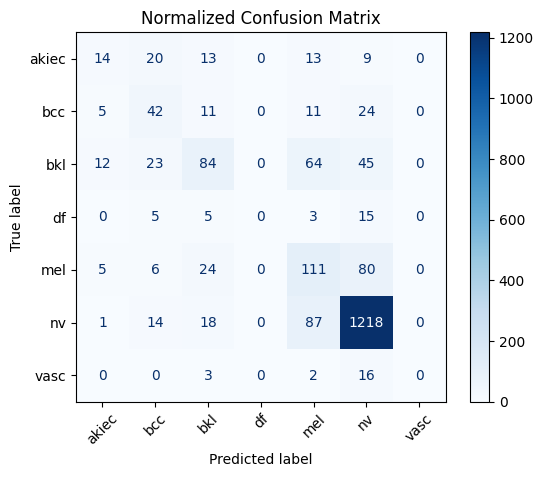

,precision,recall,f1-score,support
akiec,0.38,0.20,0.26,69.000000
bcc,0.38,0.45,0.41,93.000000
bkl,0.53,0.37,0.44,228.000000
df,0.00,0.00,0.00,28.000000
mel,0.38,0.49,0.43,226.000000
nv,0.87,0.91,0.89,1338.000000
vasc,0.00,0.00,0.00,21.000000
accuracy,0.73,0.73,0.73,0.730000
macro avg,0.36,0.35,0.35,2003.000000
weighted avg,0.71,0.73,0.72,2003.000000


In [81]:
y_pred = model_8_l.predict([X_img_test, X_meta_test])
plot_metrics(X_img_test,X_meta_test,y_test,model_8_l)

### 28X28 RGB

In [82]:
X_img= reshape(df_28_rgb, meta_cols=9, df_name='df_28_rgb')   #where X = img tensor, and y = label

## Metadata Input

X_meta = meta_eda(df_28_rgb, meta_cols, df_name='df_28_rgb')

Reshaping for df_28_rgb - 28*28*3 - RGB
The EDA process for df_28_rgb finish successfully


In [83]:
model_28_rgb = compile_model(X_img, X_meta,y)

Model: "SkinLesion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 32)     │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 14, 14, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 7, 7, 64)       │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 3136)           │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │            800 │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │        200,768 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32)             │            128 │ dense_7[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64)             │            256 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ batch_normalization_4… │
│ (Concatenate)             │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          6,208 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            455 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 228,007 (890.65 KB)

 Trainable params: 227,815 (889.90 KB)

 Non-trainable params: 192 (768.00 B)

In [84]:
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_img, X_meta, y, test_size=0.2, random_state=42) 
score_28_rgb = fit_model(X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test, model_28_rgb)
results['28x28_RGB'] = score_28_rgb

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5628 - f1_score: 0.2072 - loss: 1.2683 - precision_2: 0.7771 - recall_2: 0.4261 - val_accuracy: 0.7159 - val_f1_score: 0.2056 - val_loss: 0.7736 - val_precision_2: 0.8613 - val_recall_2: 0.6046
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7187 - f1_score: 0.3259 - loss: 0.7682 - precision_2: 0.8523 - recall_2: 0.6124 - val_accuracy: 0.6780 - val_f1_score: 0.1939 - val_loss: 1.1442 - val_precision_2: 0.7045 - val_recall_2: 0.6725
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7431 - f1_score: 0.4043 - loss: 0.6908 - precision_2: 0.8652 - recall_2: 0.6416 - val_accuracy: 0.7219 - val_f1_score: 0.4182 - val_loss: 0.6829 - val_precision_2: 0.7968 - val_recall_2: 0.6655
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7561 - f1_score: 0.4431 - loss: 0.6415 - precision_2: 0.8730 - recall_2: 0.6632 - val_accuracy: 0.7399 - val_f1_score: 0.3927 - val_loss: 0.7037 - va

It seems that for 28bits we have some records in terms of `df` and `vasc`. Let's take `vasc` as example -->
* We got that the models identify correctly 4 cases, however 7 records was missclassified as `nv` and we got 17 cases of false cases.
* On the other hand, with `akiec` if we compared with RGB (first model) we see an improvement in the recall feature and also 29 cases missclassified as `mel` type.
We can say that larger resolutions gives the model more visual clues, and also color helps when the resolution is highn enough

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


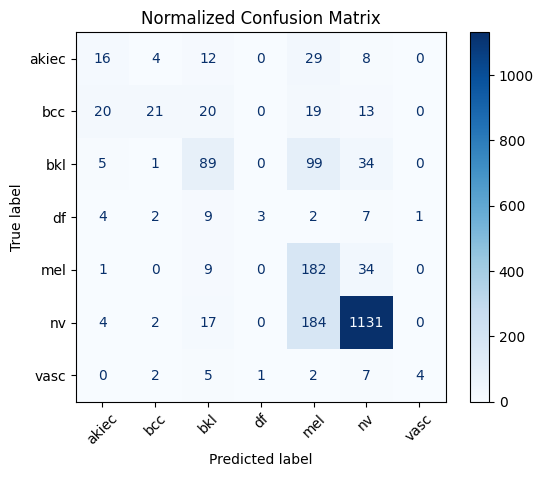

,precision,recall,f1-score,support
akiec,0.32,0.23,0.27,69.000000
bcc,0.66,0.23,0.34,93.000000
bkl,0.55,0.39,0.46,228.000000
df,0.75,0.11,0.19,28.000000
mel,0.35,0.81,0.49,226.000000
nv,0.92,0.85,0.88,1338.000000
vasc,0.80,0.19,0.31,21.000000
accuracy,0.72,0.72,0.72,0.720000
macro avg,0.62,0.40,0.42,2003.000000
weighted avg,0.78,0.72,0.73,2003.000000


In [85]:
y_pred = model_28_rgb.predict([X_img_test, X_meta_test])
plot_metrics(X_img_test,X_meta_test,y_test,model_28_rgb)

### 28*28 Grayscale

In [86]:
X_img= reshape(df_28_l, meta_cols=9, df_name='df_28_l')   #where X = img tensor, and y = label

## Metadata Input

X_meta = meta_eda(df_28_l, meta_cols, df_name='df_28_l')

Reshaping for df_28_l - 28*28*1 - grayscale
The EDA process for df_28_l finish successfully


In [87]:
model_28_l = compile_model(X_img, X_meta,y)

Model: "SkinLesion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 14, 14, 32)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 7, 7, 64)       │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 24)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 3136)           │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │            800 │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │        200,768 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32)             │            128 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64)             │            256 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 96)             │              0 │ batch_normalization_6… │
│ (Concatenate)             │                        │                │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │          6,208 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 7)              │            455 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 227,431 (888.40 KB)

 Trainable params: 227,239 (887.65 KB)

 Non-trainable params: 192 (768.00 B)

In [88]:
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_img, X_meta, y, test_size=0.2, random_state=42) 
score_28_l = fit_model(X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test, model_28_l)
results['28x28_L'] = score_28_l

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4693 - f1_score: 0.1895 - loss: 1.5029 - precision_3: 0.6630 - recall_3: 0.3027 - val_accuracy: 0.6960 - val_f1_score: 0.1795 - val_loss: 0.8286 - val_precision_3: 0.9215 - val_recall_3: 0.5512
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7193 - f1_score: 0.3026 - loss: 0.7949 - precision_3: 0.8519 - recall_3: 0.6077 - val_accuracy: 0.7334 - val_f1_score: 0.2605 - val_loss: 0.7373 - val_precision_3: 0.9010 - val_recall_3: 0.5951
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7187 - f1_score: 0.3074 - loss: 0.7421 - precision_3: 0.8623 - recall_3: 0.6238 - val_accuracy: 0.6335 - val_f1_score: 0.2153 - val_loss: 0.9615 - val_precision_3: 0.6746 - val_recall_3: 0.5921
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7337 - f1_score: 0.3555 - loss: 0.7119 - precision_3: 0.8676 - recall_3: 0.6316 - val_accuracy: 0.7339 - val_f1_score: 0.3275 - val_loss: 0.6834 - va

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


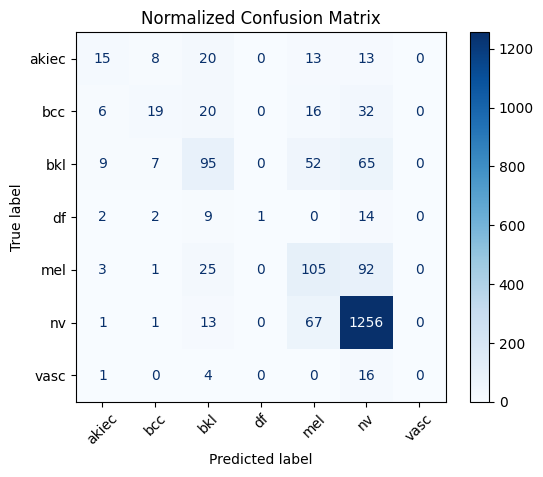

,precision,recall,f1-score,support
akiec,0.41,0.22,0.28,69.000000
bcc,0.50,0.20,0.29,93.000000
bkl,0.51,0.42,0.46,228.000000
df,1.00,0.04,0.07,28.000000
mel,0.42,0.46,0.44,226.000000
nv,0.84,0.94,0.89,1338.000000
vasc,0.00,0.00,0.00,21.000000
accuracy,0.74,0.74,0.74,0.740000
macro avg,0.53,0.33,0.35,2003.000000
weighted avg,0.72,0.74,0.72,2003.000000


In [89]:
y_pred = model_28_l.predict([X_img_test, X_meta_test])
plot_metrics(X_img_test,X_meta_test,y_test,model_28_l)

It seems that bigger picture in grayscale performs poorly than image in colors. However it happened the opposite with small pictures in grayscale compared with RGB, because color doesn't help when the image is too small, it is mostly noise. As next steps, although our current model presents solid performance - specially for 28*28*rgb, there are still some classes to improve.
For this, we can try

* Image Augmentation --> to address class imbalance
* Transfer Learning such as MobileNet or ResNet50